# WiDS Datathon 2024 Challenge #2

task is to predict the patient's Metastatic Diagnosis Period in the Test Dataset using the provided characteristics and information about the patient.

# 1. Imports and Installs

In [1]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.9 MB/s eta 0:00:00


In [2]:
# Imports

import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
# Define RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

import warnings
warnings.filterwarnings("ignore")

# Set seed for reproducibility
seed = 42

# Display settings
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', 200)

In [6]:
df_train = pd.read_csv('train_wids.csv')
print(f"Training Data Shape: {str(df_train.shape)}")

df_test = pd.read_csv('test_wids.csv')
print(f"Testing data shape: {str(df_test.shape)}")

# solution
solution_raw = pd.read_csv('solution_template.csv')
print(f"Solution data shape: {str(solution_raw.shape)}")

Training Data Shape: (13173, 152)
Testing data shape: (5646, 151)
Solution data shape: (5646, 2)


In [7]:
df_train.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
count,13173.000000,13173.000000,13173.000000,4102.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13173.000000,13168.000000,13173.000000,1.316800e+04,13168.000000,13168.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13168.000000,13168.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13168.000000,13168.000000,13173.000000,13173.000000,13173.000000,13140.000000,13170.000000,13173.000000,13173.000000,13170.000000,13153.000000,13173.000000,13156.000000,13146.000000,13114.000000,13170.000000,13170.000000,13169.000000,13164.000000,13144.000000,12993.000000,13173.000000,13021.000000,13173.000000,13173.000000,13173.000000,13173.000000,13149.000000,13173.000000,13167.000000,13161.000000,13161.00000,13145.000000,13173.000000,13173.000000,13173.000000,13151.000000,13173.000000,13157.000000,13157.000000,13155.000000,13157.000000,13157.000000,13173.000000,13173.000000,13154.000000,13173.000000,13157.000000,13173.000000,13173.000000,13173.000000,13170.000000,13160.000000,13164.000000,13173.000000,13173.000000,13173.000000,13173.000000,13172.000000,13142.000000,13173.000000,13163.0

# 2. Data Preprocessing

1. Remove columns with high null values
2. Replacing null values
3. Correct data

metastatic_first_novel_treatment_type    13162
metastatic_first_novel_treatment         13162
bmi                                       9071
patient_race                              6657
payer_type                                1765
Average of Apr-14                          180
Average of Jun-14                          152
Average of Oct-13                           59
Average of Jul-18                           46
Average of Dec-18                           33
Average of Jan-13                           33
Average of Jul-17                           31
Average of Mar-14                           29
Average of Apr-15                           28
Average of Sep-13                           27
Average of Nov-14                           24
Average of Aug-15                           22
Average of Oct-17                           21
Average of Jun-13                           20
Average of May-16                           19
Average of Dec-15                           18
Average of Au

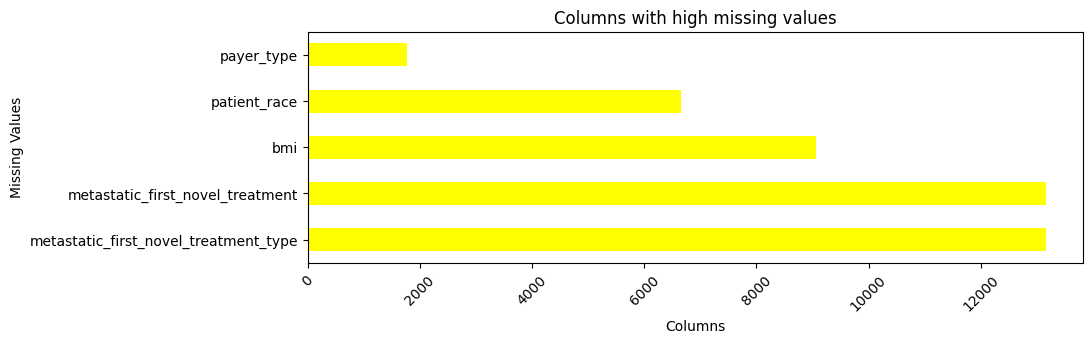

In [8]:
# First visualize high missing values
plt.figure(figsize = (10, 3))
missing_values = df_train.isna().sum().sort_values(ascending=False)
print(missing_values)

missing_values.head(5).plot(kind = 'barh', color = 'yellow')
plt.title('Columns with high missing values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.ylabel('Missing Values')
plt.show()

In [9]:
# Check the missing values for testing data.
missing_values = df_test.isna().sum().sort_values(ascending=False)
print(missing_values)

metastatic_first_novel_treatment_type    5639
metastatic_first_novel_treatment         5639
bmi                                      3941
patient_race                             2785
payer_type                                785
Average of Apr-14                          95
Average of Jun-14                          79
Average of Oct-13                          27
Average of Dec-18                          23
Average of Mar-14                          17
Average of Jul-18                          16
Average of Oct-17                          15
Average of Aug-15                          15
Average of Sep-13                          14
Average of Jul-17                          13
Average of Apr-15                          10
Average of Nov-14                           9
Average of Jan-13                           9
Average of Nov-18                           8
Average of Jun-13                           7
Average of Aug-18                           7
Average of Mar-18                 

Here out of the 5 large missing values columns, the 'metastatic first novel treatment', 'metastatic first novel treatment type' can be ignored, because they give data after diagnosis.
Also with few manual feature selection trials, we found out 'bmi' is also not useful. And as it has huge number of null values and filling up bmi with some generic value like mean/mode will likely add too much noise.
But '**patient_race**' is genetic factor which has good impact and '**payer_type**' is socio-economic factor, which may turn out useful. So we can find a way to fill out their missing values.

Dropping Null Value columns

In [10]:
# Dropping columns that contains high missing values -
# 'bmi', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'

df_train = df_train.drop(['bmi', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'], axis=1)
df_test = df_test.drop(['bmi', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'], axis=1)

Now we will focus on filling up missing values one by one for each of these columns.

In [11]:
# In case of payer type, we will go ahead with 'commercial' type. Because it is most likely payment mode in US.

df_train['payer_type'] = df_train['payer_type'].fillna('COMMERCIAL')
df_test['payer_type'] = df_test['payer_type'].fillna('COMMERCIAL')

In [12]:
# Checking patient_race.

print(df_train['patient_race'].value_counts(dropna=False, normalize=True))
print(df_test['patient_race'].value_counts(dropna=False, normalize=True))

patient_race
NaN         0.505352
White       0.270629
Black       0.087983
Hispanic    0.061262
Other       0.046459
Asian       0.028315
Name: proportion, dtype: float64
patient_race
NaN         0.493270
White       0.277010
Black       0.083953
Hispanic    0.062876
Other       0.054021
Asian       0.028870
Name: proportion, dtype: float64


In case of patient_race, we are filling up the value of the race who was least reported in the zip3 of patient.

Because if there is no data available for the race, it mostly means the patient is not comfortable to disclose their race.

In [13]:
# filling up missing race.

# List of race-related columns
race_columns = [
    'race_white', 'race_black', 'race_asian',
    'race_native', 'race_pacific', 'race_other',
    'race_multiple'
]

# Corresponding race labels
race_labels = [
    'White', 'Black', 'Asian',
    'Native', 'Pacific', 'Other',
    'Multiple'
]

# Function to fill missing 'patient_race' values
def fill_missing_race(row):
    if pd.isnull(row['patient_race']):
        # Extract the race-related values for the row
        race_values = row[race_columns].astype(float)
        # Find the index of the minimum value
        min_index = race_values.idxmin()
        # Return the corresponding race label
        return race_labels[race_columns.index(min_index)]
    else:
        return row['patient_race']

# Apply the function to the DataFrame
df_train['patient_race'] = df_train.apply(fill_missing_race, axis=1)
df_test['patient_race'] = df_test.apply(fill_missing_race, axis=1)


In [ ]:
# checking the patient_race missing values count.

train_missing = df_train['patient_race'].isnull().sum()
test_missing = df_test['patient_race'].isnull().sum()

print(train_missing)
print(test_missing)

0
0


In [ ]:
# Next - temperature
df_train[df_train['Average of Apr-14'].isna()].head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
53,453009,Other,COMMERCIAL,NY,113,Northeast,Middle Atlantic,55,F,C50919,Malignant neoplasm of unsp site of unspecified female breast,C792,46369.69,9949.13,42.36,10.70,10.49,11.74,14.15,13.40,14.47,12.42,7.74,4.90,49.28,50.72,49.93,9.78,33.86,6.44,3.40,55.50,77986.38,2.82,1.90,2.99,3.14,3.95,8.04,9.98,16.70,12.75,17.58,20.18,37.76,37986.75,51.50,16083.58,659279.4,1814.29,34.82,17.28,25.68,20.64,21.96,14.45,36.40,45.11,61.52,6.19,20.68,0.0,42.19,4.54,33.48,0.47,0.03,12.61,6.65,27.44,9.51,10.71,22.59,42.64,8.71,2.41,33.51,30.81,38.44,51.27,60.14,71.98,78.64,71.34,64.54,56.15,42.03,34.93,24.42,26.97,33.92,NaN,61.76,NaN,74.75,71.51,66.77,55.65,41.72,38.32,26.62,20.97,34.39,50.56,66.82,69.84,76.02,75.35,71.20,54.72,48.96,46.43,30.09,35.16,46.64,51.34,60.55,72.67,77.19,77.67,70.22,56.95,45.83,35.54,35.45,37.99,37.09,56.75,59.79,71.37,76.24,72.29,69.38,60.93,43.01,32.70,27.77,37.69,37.95,47.68,65.17,70.33,77.22,77.83,69.93,55.92,42.16,37.26,362
84,836794,Pacific,COMMERCIAL,NY,110,Northeast,Middle Atlantic,44,F,1741,Malignant neoplasm of central portion of female breast,C773,18744.07,2898.56,47.13,11.01,11.64,9.71,9.83,10.94,11.97,11.36,9.85,13.66,47.61,52.39,53.63,7.56,27.55,11.25,3.49,57.13,126078.20,1.80,1.60,2.92,1.79,1.98,3.95,5.09,12.47,10.45,17.98,39.98,57.95,51248.07,78.74,6012.00,820537.0,1965.00,30.73,10.08,20.55,18.84,26.04,24.51,50.54,46.26,54.46,4.19,18.43,0.0,60.92,9.26,18.79,0.26,0.01,7.28,3.48,12.81,10.68,6.91,6.89,36.71,3.40,3.54,33.51

Here we can clearly see that the temparature of given month can be derived from its neighbouring months. We will use interpolate() function with linear method for calcuating the null values.

In [ ]:
# Interpolate on Avergae Temperature of months

# get month columns
month_columns = [col for col in df_train.columns if 'Average of' in col]

df_train[month_columns] = df_train[month_columns].interpolate(method='linear', axis=1)

df_test[month_columns] = df_test[month_columns].interpolate(method='linear', axis=1)

In [ ]:
# Checking Remaining columns with null values are:
null_counts = df_train.isnull().sum()
colunms_with_null = null_counts[null_counts > 0]
print(colunms_with_null)

Average of Jan-13                   33
family_size                          5
self_employed                        5
farmer                               5
family_dual_income                   5
income_household_median              5
income_household_under_5             5
income_household_5_to_10             5
income_household_10_to_15            5
income_household_15_to_20            5
income_household_20_to_25            5
income_household_25_to_35            5
income_household_35_to_50            5
poverty                              5
limited_english                      5
income_household_50_to_75            5
income_household_75_to_100           5
income_household_100_to_150          5
income_household_150_over            5
income_household_six_figure          5
home_ownership                       5
home_value                           5
rent_median                          5
rent_burden                          5
Average of Jan-16                    0
Average of Feb-16        

In [ ]:
# Filter rows where 'Average of Jan-13' is null
null_jan_13_rows = df_train[df_train['Average of Jan-13'].isnull()]

# Select only the month columns for the filtered rows
month_columns_only = null_jan_13_rows[month_columns].head()

# Print the DataFrame with only the month columns
print(month_columns_only.to_string(index=False))

 Average of Jan-13  Average of Feb-13  Average of Mar-13  Average of Apr-13  Average of May-13  Average of Jun-13  Average of Jul-13  Average of Aug-13  Average of Sep-13  Average of Oct-13  Average of Nov-13  Average of Dec-13  Average of Jan-14  Average of Feb-14  Average of Mar-14  Average of Apr-14  Average of May-14  Average of Jun-14  Average of Jul-14  Average of Aug-14  Average of Sep-14  Average of Oct-14  Average of Nov-14  Average of Dec-14  Average of Jan-15  Average of Feb-15  Average of Mar-15  Average of Apr-15  Average of May-15  Average of Jun-15  Average of Jul-15  Average of Aug-15  Average of Sep-15  Average of Oct-15  Average of Nov-15  Average of Dec-15  Average of Jan-16  Average of Feb-16  Average of Mar-16  Average of Apr-16  Average of May-16  Average of Jun-16  Average of Jul-16  Average of Aug-16  Average of Sep-16  Average of Oct-16  Average of Nov-16  Average of Dec-16  Average of Jan-17  Average of Feb-17  Average of Mar-17  Average of Apr-17  Average of 

okay, we can see, the Average of Jan-13 is null becuase it is first column. So no data available to calculate its values. In this case, after checking. the non null values for this columns, we can fill null values with Average of Feb-13 column values for given row.

In [ ]:
# Filling null values of Average of Jan-13.

# fill with Average of Feb-13 for the null rows.
df_train.loc[null_jan_13_rows.index, 'Average of Jan-13'] = df_train.loc[null_jan_13_rows.index, 'Average of Feb-13']

null_jan_13_rows = df_test[df_test['Average of Jan-13'].isnull()]
df_test.loc[null_jan_13_rows.index, 'Average of Jan-13'] = df_test.loc[null_jan_13_rows.index, 'Average of Feb-13']

In [ ]:
# Now count the null values of the column.
df_train['Average of Jan-13'].isnull().sum()

# We see its zero now.

0

In [ ]:
# Remaining columns with null values are:
null_counts = df_train.isnull().sum()
colunms_with_null = null_counts[null_counts > 0]
print(colunms_with_null)

family_size                    5
family_dual_income             5
income_household_median        5
income_household_under_5       5
income_household_5_to_10       5
income_household_10_to_15      5
income_household_15_to_20      5
income_household_20_to_25      5
income_household_25_to_35      5
income_household_35_to_50      5
income_household_50_to_75      5
income_household_75_to_100     5
income_household_100_to_150    5
income_household_150_over      5
income_household_six_figure    5
home_ownership                 5
home_value                     5
rent_median                    5
rent_burden                    5
self_employed                  5
farmer                         5
poverty                        5
limited_english                5
dtype: int64


In [ ]:
# Remaining columns with null values for test:
null_counts = df_test.isnull().sum()
colunms_with_null = null_counts[null_counts > 0]
print(colunms_with_null)

Series([], dtype: int64)


We see no null values left for test data. Good. But lets continue further pre processing for training data as it still has null values for certian columns.

In [ ]:
# We see each of those left null columns have exact 5 rows empty. Let us see if there is any overlap for those rows and their column values.
# We will see empty row values for 'family_size' column.

rows = df_train[df_train.family_size.isna()]
print(rows.to_string())

       patient_id patient_race  payer_type patient_state  patient_zip3 Region            Division  patient_age patient_gender breast_cancer_diagnosis_code                                  breast_cancer_diagnosis_desc metastatic_cancer_diagnosis_code  population  density  age_median  age_under_10  age_10_to_19  age_20s  age_30s  age_40s  age_50s  age_60s  age_70s  age_over_80  male  female  married  divorced  never_married  widowed  family_size  family_dual_income  income_household_median  income_household_under_5  income_household_5_to_10  income_household_10_to_15  income_household_15_to_20  income_household_20_to_25  income_household_25_to_35  income_household_35_to_50  income_household_50_to_75  income_household_75_to_100  income_household_100_to_150  income_household_150_over  income_household_six_figure  income_individual_median  home_ownership  housing_units  home_value  rent_median  rent_burden  education_less_highschool  education_highschool  education_some_college  education_b

We see, all the columns that are left with Null values, have Null values in these 5 rows only. They are all belonging to zip3 = 772.

In [ ]:
# check if there are any valid values for zip 3 = 772.

df_train[df_train['patient_zip3'] == 772]

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
3985,757384,Native,COMMERCIAL,TX,772,South,West South Central,43,F,C50911,Malignant neoplasm of unsp site of right female breast,C773,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.81,83.57,79.69,71.54,56.36,55.84,49.87,51.02,59.94,71.24,74.85,80.84,85.18,84.81,80.69,73.54,62.15,58.43,51.56,58.81,64.94,69.85,75.39,82.04,87.24,83.8,82.73,75.83,67.04,56.38,58.15,65.85,67.7,71.45,75.51,81.86,85.63,83.71,79.54,70.17,65.8,51.79,46.29,57.91,66.5,65.66,79.57,84.9,85.55,85.06,80.93,71.28,56.46,53.85,40
4404,367375,Native,COMMERCIAL,TX,772,South,West South Central,61,F,1743,Malignant neoplasm of lower-inner quadrant of female breast,C7951,4459.0,3376.1,20.6,0.0,35.3,62.1,1.5,0.8,0.0,0.2,0.0,0.0,47.1,52.9,0.9,0.2,98.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4316.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,44.8,41.7,13.5,55.2,73.0,30.7,18.8,NaN,NaN,47.6,23.0,20.1,0.0,0.0,1.7,7.6,18.2,4.6,NaN,NaN,16.2,4.5,1.6,52.36,56.4,59.25,66.05,73.87,82.56,82.95,84.99,81.4,70.52,56.23,49.51,47.31,53.35,57.7,67.66,73.92,84.1,82.81,83.57,79.69,71.54,56.36,55.84,49.87,51.02,59.94,71.24,74.85,80.84,85.18,84.81,80.69,73.54,62.

In [ ]:
# No data for given zip. So we will check with state (TX)

df_train[df_train['patient_state'] == 'TX'].head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
24,752174,Black,MEDICARE ADVANTAGE,TX,770,South,West South Central,77,F,C50919,Malignant neoplasm of unsp site of unspecified female breast,C773,33353.72,1836.73,34.71,13.51,13.54,15.52,15.84,12.80,11.74,9.70,5.05,2.28,49.98,50.02,42.93,12.65,39.89,4.53,3.39,51.24,66076.27,4.08,3.09,4.35,4.47,4.71,10.18,12.72,17.11,10.93,12.79,15.56,28.36,37965.46,49.70,12096.22,247842.7,1193.59,32.92,21.30,22.50,23.68,19.41,13.10,32.51,47.45,66.17,6.71,17.26,0.27,47.42,22.50,7.07,0.52,0.04,11.34,11.12,44.48,9.89,18.73,13.97,27.93,22.54,3.77,53.62,57.57,60.04,65.86,74.01,82.82,83.19,84.39,81.61,71.29,57.74,50.59,48.54,54.11,58.25,68.19,73.46,83.03,82.81,83.96,79.68,72.08,57.28,56.25,49.87,51.89,61.35,71.90,76.12,81.30,85.22,84.29,79.90,73.49,63.61,59.46,51.92,58.94,65.89,69.98,75.39,82.04,86.22,83.80,82.57,75.58,67.20,58.23,59.44,65.98,67.99,71.59,75.64,81.66,85.04,83.61,79.60,71.53,66.63,53.12,47.43,61.48,66.91,66.50,79.54,84.57,84.85,85.09,80.61,72.46,58.14,55.77,118
56,610225,Pacific,COMMERCIAL,TX,766,South,West South Central,91,F,C50919,Malignant neoplasm of unsp site of unspecified female breast,C7951,2979.75,28.71,42.62,12.38,13.07,10.68,11.33,11.36,13.86,13.63,9.43,4.25,51.82,48.18,54.45,13.52,24.78,7.24,3.25,47.60,59424.09,3.04,2.41,4.22,5.94,4.47,10.77,12.89,17.97,12.88,15.60,9.79,25.39,31102.44,80.01,1065.30,147375.6,850.52,26.71,14.05,34.11,34.62,12.12,5.09,17.21,37.18,56.24,4.46,13.23,12.05,82.10,7.48,0.38,0.37,0.03,3.11,6.53,18.08,17.51,13.84,2.06

In [ ]:
# Se there are some valid values for TX. Let us check for closest zips.

rows = df_train[(df_train['patient_state'] == 'TX') & (df_train['patient_zip3'] < 776)].head()
print(rows.to_string())

    patient_id patient_race          payer_type patient_state  patient_zip3 Region            Division  patient_age patient_gender breast_cancer_diagnosis_code                                  breast_cancer_diagnosis_desc metastatic_cancer_diagnosis_code  population  density  age_median  age_under_10  age_10_to_19  age_20s  age_30s  age_40s  age_50s  age_60s  age_70s  age_over_80   male  female  married  divorced  never_married  widowed  family_size  family_dual_income  income_household_median  income_household_under_5  income_household_5_to_10  income_household_10_to_15  income_household_15_to_20  income_household_20_to_25  income_household_25_to_35  income_household_35_to_50  income_household_50_to_75  income_household_75_to_100  income_household_100_to_150  income_household_150_over  income_household_six_figure  income_individual_median  home_ownership  housing_units  home_value  rent_median  rent_burden  education_less_highschool  education_highschool  education_some_college  educa

In [ ]:
# okay. We will add average of all other states here for missing values.

def mixed_imputation(df, group_col):
    for column in df.columns:
        if column != group_col:  # Exclude the group column
            # If the column is numerical, then mean imputation
            if df[column].dtype in [np.dtype('float_'), np.dtype('int_')]:
                mean_impute = df.groupby(group_col)[column].mean()
                df[column] = df[column].fillna(df[group_col].map(mean_impute))

            # If the column is categorical, apply mode imputation
            else :
                mode_impute = df.groupby(group_col)[column].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
                df[column] = df[column].fillna(df[group_col].map(mode_impute))

    return df

# Impute missing values
df_train = mixed_imputation(df=df_train, group_col='patient_state')
df_test = mixed_imputation(df=df_test, group_col='patient_state')

In [ ]:
# Check Null Values now:

null_counts = df_train.isnull().sum()
colunms_with_null = null_counts[null_counts > 0]
print(colunms_with_null)

metastatic_diagnosis_period         0
patient_id                          0
patient_race                        0
payer_type                          0
patient_state                       0
Average of Oct-17                   0
Average of Nov-17                   0
Average of Dec-17                   0
Average of Jan-18                   0
Average of Feb-18                   0
Average of Mar-18                   0
Average of Apr-18                   0
Average of May-18                   0
density                             0
age_median                          0
age_under_10                        0
age_10_to_19                        0
age_20s                             0
age_30s                             0
age_40s                             0
age_50s                             0
age_60s                             0
age_70s                             0
age_over_80                         0
male                                0
female                              0
married     

Missing values are added. Now Handle inconsistencies. Drop constant columns like gender, etc.

In [ ]:
# We will check the breast cancer code.
# Get distinct values of gender
print(df_train['patient_gender'].unique())

df_train.groupby(['breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc'], as_index=False)['patient_id'].count()

['F']


,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,patient_id
0,1741,Malignant neoplasm of central portion of female breast,86
1,1742,Malignant neoplasm of upper-inner quadrant of female breast,110
2,1743,Malignant neoplasm of lower-inner quadrant of female breast,45
3,1744,Malignant neoplasm of upper-outer quadrant of female breast,402
4,1745,Malignant neoplasm of lower-outer quadrant of female breast,81
5,1746,Malignant neoplasm of axillary tail of female breast,9
6,1748,Malignant neoplasm of other specified sites of female breast,337
7,1749,"Malignant neoplasm of breast (female), unspecified",1947
8,19881,Secondary malignant neoplasm of breast,12
9,C5001,"Malignant neoplasm of nipple and areola, female",1


Now there are only Female Patients in our dataset. So we can also check the possible Breast Cancer Codes to see if all are for females.

In [ ]:
# We see, code C509 is only 3 digit. So let's move it to its according 4 digits code (C5091).
df_train['breast_cancer_diagnosis_code'] = df_train['breast_cancer_diagnosis_code'].replace({
    # Recode male to female
    'C50122': 'C50112', 'C50221': 'C50211', 'C50421': 'C50411', 'C50922': 'C50912',
    # Recode categories
    'C509': 'C5091'
})

df_test['breast_cancer_diagnosis_code'] = df_test['breast_cancer_diagnosis_code'].replace({
    # Recode male to female
    'C50122': 'C50112', 'C50221': 'C50211', 'C50421': 'C50411', 'C50922': 'C50912',
    # Recode categories
    'C509': 'C5091'
})

# Feature Engineering

We will be creating new features from existing data. Features to be created:

1. age_under_40: as the patients udenr 40 are mostly impacted.
2. housing_details
4. employment_details - will directly use the column 'self_employed'
5. personal_income - will directly use the column 'income_individual_median'

In [ ]:
# 1. age_under_40

df_train['age_under_40'] = df_train['patient_age'].apply(lambda x: 1 if x < 40 else 0)

df_train.head()

df_test['age_under_40'] = df_test['patient_age'].apply(lambda x: 1 if x < 40 else 0)

In [ ]:
# 2. housing details

# creating normalized_housing_units feature. This uses housing_units and density column.

df_train['housing_density'] = df_train['housing_units'] / df_train['density']
df_train['normalized_housing_units'] = (df_train['housing_units'] - df_train['housing_units'].mean()) / df_train['housing_units'].std()

df_test['housing_density'] = df_test['housing_units'] / df_test['density']
df_test['normalized_housing_units'] = (df_test['housing_units'] - df_test['housing_units'].mean()) / df_test['housing_units'].std()


df_train.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period,age_under_40,housing_density,normalized_housing_units
0,268700,Pacific,COMMERCIAL,AR,724,South,West South Central,39,F,C50912,Malignant neoplasm of unspecified site of left female breast,C773,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191,1,18.319618,-1.223128
1,484983,White,COMMERCIAL,IL,629,Midwest,East North Central,55,F,C50412,Malig neoplasm of upper-outer quadrant of left female breast,C773,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9.19,5.21,88.75

In [ ]:
# Create feature that tells how likely is the patient to be having education higher than or equal to high school.

# training data
df_train['education_highschool_or_above'] = df_train['education_highschool'] + df_train['education_some_college'] + df_train['education_bachelors'] + df_train['education_graduate'] + df_train['education_stem_degree']

# Normalize the education_highschool_or_above feature
scaler = MinMaxScaler()
df_train['education_highschool_or_above_normalized'] = scaler.fit_transform(df_train[['education_highschool_or_above']])


# testing data
df_test['education_highschool_or_above'] = df_test['education_highschool'] + df_test['education_some_college'] + df_test['education_bachelors'] + df_test['education_graduate'] + df_test['education_stem_degree']

# Normalize the education_highschool_or_above feature
scaler = MinMaxScaler()
df_test['education_highschool_or_above_normalized'] = scaler.fit_transform(df_test[['education_highschool_or_above']])

df_train.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period,age_under_40,housing_density,normalized_housing_units,education_highschool_or_above,education_highschool_or_above_normalized
0,268700,Pacific,COMMERCIAL,AR,724,South,West South Central,39,F,C50912,Malignant neoplasm of unspecified site of left female breast,C773,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191,1,18.319618,-1.223128,122.24,0.362231
1,484983,White,COMMERCIAL,IL,629,Midwest,East North Central,55,F,C50412,Malig neoplasm of upper-outer quadrant of left female breast,C773,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92

# Data Preperation

In [ ]:
# Generating X and Y.

X = df_train.drop(['patient_id', 'metastatic_diagnosis_period'], axis=1)
icd = df_train.breast_cancer_diagnosis_code.str.startswith('17').astype(int)
y = df_train['metastatic_diagnosis_period']

print(X.shape, y.shape)
X.head()

(13173, 151) (13173,)


,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,age_under_40,housing_density,normalized_housing_units,education_highschool_or_above,education_highschool_or_above_normalized
0,Pacific,COMMERCIAL,AR,724,South,West South Central,39,F,C50912,C773,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,1,18.319618,-1.223128,122.24,0.362231
1,White,COMMERCIAL,IL,629,Midwest,East North Central,55,F,C50412,C773,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9.19,5.21,88.75,6.44,0.53,0.19,0.05,0.61,3.42,2.78,20.16,16.94,0.43,26.26,6.93,9.71,34.85,36.15,39.41,54.63,65.41,73.89,74.07,74.37,70.4

In [ ]:
# rename the average temp columns for formatting purposes.

def rename_columns(col_name):
    if 'Average of' in col_name:
        # Replace spaces and hyphens
        new_col_name = col_name.replace(' ', '_').replace('-', '')
        # Convert to lower case
        return new_col_name.lower()
    else:
        return col_name

X = X.rename(columns=rename_columns)

In [ ]:
# rename the average temp columns for formatting purposes. test data

def rename_columns(col_name):
    if 'Average of' in col_name:
        # Replace spaces and hyphens
        new_col_name = col_name.replace(' ', '_').replace('-', '')
        # Convert to lower case
        return new_col_name.lower()
    else:
        return col_name

df_test = df_test.rename(columns=rename_columns)

In [ ]:
X.head()

,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,average_of_jan13,average_of_feb13,average_of_mar13,average_of_apr13,average_of_may13,average_of_jun13,average_of_jul13,average_of_aug13,average_of_sep13,average_of_oct13,average_of_nov13,average_of_dec13,average_of_jan14,average_of_feb14,average_of_mar14,average_of_apr14,average_of_may14,average_of_jun14,average_of_jul14,average_of_aug14,average_of_sep14,average_of_oct14,average_of_nov14,average_of_dec14,average_of_jan15,average_of_feb15,average_of_mar15,average_of_apr15,average_of_may15,average_of_jun15,average_of_jul15,average_of_aug15,average_of_sep15,average_of_oct15,average_of_nov15,average_of_dec15,average_of_jan16,average_of_feb16,average_of_mar16,average_of_apr16,average_of_may16,average_of_jun16,average_of_jul16,average_of_aug16,average_of_sep16,average_of_oct16,average_of_nov16,average_of_dec16,average_of_jan17,average_of_feb17,average_of_mar17,average_of_apr17,average_of_may17,average_of_jun17,average_of_jul17,average_of_aug17,average_of_sep17,average_of_oct17,average_of_nov17,average_of_dec17,average_of_jan18,average_of_feb18,average_of_mar18,average_of_apr18,average_of_may18,average_of_jun18,average_of_jul18,average_of_aug18,average_of_sep18,average_of_oct18,average_of_nov18,average_of_dec18,age_under_40,housing_density,normalized_housing_units,education_highschool_or_above,education_highschool_or_above_normalized
0,Pacific,COMMERCIAL,AR,724,South,West South Central,39,F,C50912,C773,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,1,18.319618,-1.223128,122.24,0.362231
1,White,COMMERCIAL,IL,629,Midwest,East North Central,55,F,C50412,C773,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9.19,5.21,88.75,6.44,0.53,0.19,0.05,0.61,3.42,2.78,20.16,16.94,0.43,26.26,6.93,9.71,34.85,36.15,39.41,54.63,65.41,73.89,74.07,74.37,70.44,57.37,42.15,33.16,26.88,28.36,40.32,56.85,66.84,75.12,72.18,77.08,67.1

In [ ]:
# Encode Categorical Values
cols_categorical = X.columns[X.dtypes == 'object'].to_list()
cols_categorical

['patient_race',
 'payer_type',
 'patient_state',
 'Region',
 'Division',
 'patient_gender',
 'breast_cancer_diagnosis_code',
 'metastatic_cancer_diagnosis_code']

In [ ]:
# train the encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).fit(X[cols_categorical])

# run the encoder to get integer values for categorical columns and then combine the new df.
X_enc = pd.concat([
    X.drop(columns=cols_categorical),  # Drop the original categorical columns
    pd.DataFrame(encoder.transform(X[cols_categorical]), columns=cols_categorical)
], axis=1)

In [ ]:
df_test_enc = pd.concat([
    df_test.drop(columns=cols_categorical),  # Drop the original categorical columns
    pd.DataFrame(encoder.transform(df_test[cols_categorical]), columns=cols_categorical)
], axis=1)

# Model Building - basic and Feature Selection

In [ ]:
# Split the data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state=seed, stratify=y, test_size=.2)
print('Training size: ', X_train.shape)
print('Testing size: ', X_test.shape)

X_train.head(2)

Training size:  (10538, 151)
Testing size:  (2635, 151)


,patient_zip3,patient_age,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,average_of_jan13,average_of_feb13,average_of_mar13,average_of_apr13,average_of_may13,average_of_jun13,average_of_jul13,average_of_aug13,average_of_sep13,average_of_oct13,average_of_nov13,average_of_dec13,average_of_jan14,average_of_feb14,average_of_mar14,average_of_apr14,average_of_may14,average_of_jun14,average_of_jul14,average_of_aug14,average_of_sep14,average_of_oct14,average_of_nov14,average_of_dec14,average_of_jan15,average_of_feb15,average_of_mar15,average_of_apr15,average_of_may15,average_of_jun15,average_of_jul15,average_of_aug15,average_of_sep15,average_of_oct15,average_of_nov15,average_of_dec15,average_of_jan16,average_of_feb16,average_of_mar16,average_of_apr16,average_of_may16,average_of_jun16,average_of_jul16,average_of_aug16,average_of_sep16,average_of_oct16,average_of_nov16,average_of_dec16,average_of_jan17,average_of_feb17,average_of_mar17,average_of_apr17,average_of_may17,average_of_jun17,average_of_jul17,average_of_aug17,average_of_sep17,average_of_oct17,average_of_nov17,average_of_dec17,average_of_jan18,average_of_feb18,average_of_mar18,average_of_apr18,average_of_may18,average_of_jun18,average_of_jul18,average_of_aug18,average_of_sep18,average_of_oct18,average_of_nov18,average_of_dec18,age_under_40,housing_density,normalized_housing_units,education_highschool_or_above,education_highschool_or_above_normalized,patient_race,payer_type,patient_state,Region,Division,patient_gender,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code
928,726,75,2817.04,28.27,49.43,9.11,10.64,8.95,9.48,10.61,14.32,18.55,11.77,6.58,47.87,52.13,53.55,17.76,18.70,9.99,3.12,44.76,49426.98,2.20,2.15,7.83,9.17,7.49,11.01,14.42,16.15,15.83,10.66,3.11,13.76,26103.95,79.92,1168.35,129826.6,668.56,27.92,13.68,39.39,32.42,10.41,4.10,14.52,46.39,46.75,4.13,14.05,10.23,93.39,0.21,0.33,1.02,0.15,0.42,4.48,2.54,25.23,14.38,0.36,27.08,6.16,10.62,37.56,38.95,42.49,55.62,64.03,74.57,76.00,75.57,72.32,58.77,44.71,35.22,30.56,33.59,43.18,56.89,66.60,73.94,73.50,74.29,69.66,61.05,41.15,39.79,34.60,31.46,46.18,58.65,65.89,75.45,79.04,74.49,72.16,59.80,50.52,45.99,34.85,42.76,51.77,58.86,63.94,77.0,79.67,77.50,72.45,64.17,52.31,37.68,39.97,48.42,51.77,60.16,64.91,72.68,78.37,73.98,70.73,60.22,50.78,39.04,31.62,40.37,49.13,51.25,72.33,77.82,80.11,76.72,72.42,59.4,42.03,40.59,0,41.328263,-1.292665,132.71,0.493781,6.0,2.0,2.0,2.0,7.0,0.0,21.0,3.0
9842,907,71,28996.77,2757.96,40.64,9.87,15.30,13.14,12.18,11.46,14.15,12.52,7.14,4.23,47.63,52.37,44.47,11.39,38.24,5.89,3.46,55.71,88561.62,1.98,1.94,2.62,3.40,3.36,6.12,9.55,16.02,12.56,19.24,23.20,42.45,38429.68,56.80,9291.64,669024.6,1845.91,32.66,15.37,20.51,29.29,23.05,11.77,34.82,43.90,62.80,7.50,13.89,0.00,46.61,8.91,17.68,0.66,0.86,14.98,10.30,38.70,9.12,9.87,8.16,27.92,7.14,4.90,57.49,57.68,61.49,63.52,68.09,69.55,72.26,72.93,73.94,67.50,64.90,60.58,64.35,61.26,63.95,65.38,71.05,70.20,75.24,75.36,77.36,72.88,67.30,60.40,63.07,64.59,68.34,65.54,64.22,71.29,73.97,78.43,78.37,75.59

In [ ]:
# Fit initial model
ctb_full = CatBoostRegressor(
    random_state=seed,
    verbose=False,
    eval_metric='RMSE'
).fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

rmse(y_test, ctb_full.predict(X_test)) # 81.37

81.29144441213859

We will do feature selection on catboost model that we built just now.

In [ ]:
# Recursive Feature Selection.
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
rerun_rfe = False
if rerun_rfe == True:
    rfe_ctb_full = ctb_full.select_features(
        X                      = X_train,
        y                      = y_train,
        eval_set               = (X_test, y_test),
        features_for_select    = X_train.columns.to_list(),                         # Features that will be selected on the RFE - here, all of them
        num_features_to_select = 10,                                                # Number of features to keep from the selected
        algorithm              = EFeaturesSelectionAlgorithm.RecursiveByShapValues, # Algorithm chosen, see -> https://github.com/catboost/catboost/blob/master/catboost/tutorials/feature_selection/select_features_tutorial.ipynb
        steps                  = 20,                                                # Number of model iterations performed in the RFE
        verbose                = False,                                             # Do not print model iterations
        train_final_model      = False,                                             # Train final model after RFE is finished
        plot                   = True                                               # plot after the RFE is finished -> very helpful for understanding if we can get a better AUC with fewer variables
    )

    # Minimum loss corresponds to the lowest RMSE
    n_todrop = np.argmin(rfe_ctb_full['loss_graph']['loss_values'])
    cols_to_keep = X.drop(rfe_ctb_full['eliminated_features_names'][:n_todrop],axis=1).columns.to_list()



Columns given by algorithm:


'patient_zip3',
        'Region',
        'patient_age',
       'patient_gender',
 'breast_cancer_diagnosis_code',
'metastatic_cancer_diagnosis_code',
 'age_40s',
'housing_units',
'education_highschool',
'self_employed',
 'average_of_sep13',

 'average_of_dec13',
'average_of_jun14',
 'average_of_dec14',
'average_of_may18'


Now we did some trial and error for feature selction for each of the upcoming models. By referring to the above features that were given as significant by the algorithm, we found out the below features as most useful ones.

'payer_type',
 'patient_zip3',
'patient_state',
 'patient_age',
 'breast_cancer_diagnosis_code',
 'metastatic_cancer_diagnosis_code',
 'self_employed'

In [ ]:
# Feature Selection Manually.

cols_to_keep = ['payer_type',
 'patient_zip3',
'patient_state',
 'patient_age',
 'breast_cancer_diagnosis_code',
 'metastatic_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'self_employed']

X_short = X_enc[cols_to_keep]
X_train_short = X_train[cols_to_keep]
X_test_short = X_test[cols_to_keep]
cols_categorical_short = X_train_short.columns[X_train_short.dtypes == 'category'].to_list()

print(X_short.shape)
X_short.head()

(13173, 7)


,payer_type,patient_zip3,patient_state,patient_age,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,self_employed
0,0.0,724,2.0,39,40.0,3.0,11.82
1,0.0,629,13.0,55,26.0,3.0,9.19
2,0.0,925,4.0,59,7.0,3.0,13.21
3,1.0,900,4.0,59,39.0,3.0,21.23
4,0.0,934,4.0,71,6.0,30.0,14.53


In [ ]:
df_test_short = df_test_enc[cols_to_keep]

# Modeling

In [ ]:
# 1. CatBoost
ctb = CatBoostRegressor(
    random_state=seed,
    learning_rate=.02,
    verbose=False,
    eval_metric='RMSE'
).fit(X_train_short, y_train, eval_set=(X_test_short, y_test), use_best_model=True)

rmse(y_test, ctb.predict(X_test_short))
# 80.81448277035135

80.81448277035135

In [ ]:
# 3. LightGBM
lgbm = LGBMRegressor(
    random_state=seed,
    learning_rate=.04,
    verbose=0
).fit(X_train_short, y_train)
rmse(y_test, lgbm.predict(X_test_short))

80.97526657549739

In [ ]:
# 4. Random Forest
rf = RandomForestRegressor(
    random_state=seed,
    max_depth=6
).fit(X_train_short, y_train)
rmse(y_test, rf.predict(X_test_short))

80.994026518327

In [ ]:
# 8. LightGBM with Tweedie objective
lgbm_tw = LGBMRegressor(
    random_state=seed,
    tweedie_variance=1.1,
    n_estimators=40,
    verbosity=-1,
    objective="tweedie",
    metric="rmse"
).fit(X_train_short, y_train)
rmse(y_test, lgbm_tw.predict(X_test_short))

80.89424240180158

# Model Ensembling

In [ ]:
# Predic with Ensembling

def CV_predict(X, y, newdata, model, custom_cv, stratify_col=None, verbose=True, use_best_model=False):
    oof_preds, test_preds = {}, {}
    scores = []

    for fold, (train_ids, val_ids) in enumerate(custom_cv.split(X, stratify_col)):
        X_tr, y_tr = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]

        if use_best_model == True:
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                use_best_model=True,
                verbose=False)

        elif type(model) == XGBRegressor:
            model.fit(X_tr, y_tr, verbose=False)

        else:
            model.fit(X_tr, y_tr)

        val_preds = model.predict(X_val)
        oof_preds.update(dict(zip(val_ids, val_preds)))
        test_preds[f'fold{fold}'] = model.predict(newdata)

        score = rmse(y_val, val_preds)
        scores.append(score)
        if verbose:
            if type(model) == CatBoostRegressor:
                print(f'Fold #{fold:>2}: {score:.5f} ({model.best_iteration_:>4} rounds)')
            else:
                print(f'Fold #{fold:>2}: {score:.5f}')

    test_preds = pd.DataFrame.from_dict(test_preds)
    test_preds['mean'] = test_preds.mean(axis=1) # mean of fold-wise predictions

    oof_preds = pd.Series(oof_preds).sort_index()
    print(f'\nAvg score: {np.mean(scores):.5f} ± {np.std(scores):.5f}')
    print(f'OOF score: {rmse(y, oof_preds):.5f}')

    return oof_preds, test_preds

In [ ]:
# First, cross validation
from sklearn.model_selection import RepeatedKFold
cv = KFold(n_splits=10, shuffle=True, random_state=seed)
# cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=seed)

# Encode categories in new data as well
df_test_enc = pd.concat([
    df_test[df_test.columns[~df_test.columns.isin(cols_categorical)]],
    pd.DataFrame(encoder.transform(df_test[cols_categorical]), columns=cols_categorical)], axis=1)
df_test_short = df_test_enc[X_short.columns]

# 1. CatBoost
oof_preds_ctb, test_preds_ctb = CV_predict(X_short, y, df_test_short, ctb, cv, use_best_model=True)
# Avg score: 82.64196 ± 1.48266
# OOF score: 82.65536

Fold # 0: 79.93327 ( 749 rounds)
Fold # 1: 82.41088 ( 525 rounds)
Fold # 2: 83.48737 ( 791 rounds)
Fold # 3: 82.20112 ( 775 rounds)
Fold # 4: 80.24037 ( 766 rounds)
Fold # 5: 79.32495 ( 994 rounds)
Fold # 6: 81.51972 ( 376 rounds)
Fold # 7: 83.88244 ( 734 rounds)
Fold # 8: 80.27318 ( 825 rounds)
Fold # 9: 83.70984 ( 693 rounds)

Avg score: 81.69831 ± 1.60358
OOF score: 81.71410


In [ ]:
# 3. LightGBM
oof_preds_lgbm, test_preds_lgbm = CV_predict(X_short, y, df_test_short, lgbm, cv)
# Avg score: 82.84890 ± 1.45635
# OOF score: 82.86181

Fold # 0: 80.50842
Fold # 1: 82.60704
Fold # 2: 83.76107
Fold # 3: 82.27703
Fold # 4: 80.65863
Fold # 5: 79.40461
Fold # 6: 81.82513
Fold # 7: 83.92250
Fold # 8: 80.50445
Fold # 9: 83.99335

Avg score: 81.94622 ± 1.55610
OOF score: 81.96108


In [ ]:
# 4. Random Forest
oof_preds_rf, test_preds_rf = CV_predict(X_short, y, df_test_short, rf, cv)
# Avg score: 82.74654 ± 1.42766
# OOF score: 82.75896

Fold # 0: 80.25882
Fold # 1: 82.52109
Fold # 2: 83.52481
Fold # 3: 82.34348
Fold # 4: 80.60254
Fold # 5: 78.93009
Fold # 6: 81.42133
Fold # 7: 84.28331
Fold # 8: 80.76211
Fold # 9: 83.88377

Avg score: 81.85314 ± 1.65943
OOF score: 81.87001


In [ ]:
# 8. LightGBM with Tweedie objective
oof_preds_lgbm_tw, test_preds_lgbm_tw = CV_predict(X_short, y, df_test_short, lgbm_tw, cv)
# Avg score: 82.16356 ± 1.58585
# OOF score: 82.17889

Fold # 0: 80.12392
Fold # 1: 82.26422
Fold # 2: 83.62968
Fold # 3: 82.33767
Fold # 4: 80.41558
Fold # 5: 79.75865
Fold # 6: 81.94934
Fold # 7: 84.03407
Fold # 8: 80.03031
Fold # 9: 84.35299

Avg score: 81.88964 ± 1.65311
OOF score: 81.90635


In [ ]:
oof_preds_combined = pd.DataFrame({
    'model1': oof_preds_ctb,
    'model3': oof_preds_lgbm,
    'model4': oof_preds_rf,
    'model8': oof_preds_lgbm_tw
})

test_preds_combined = pd.DataFrame({
    'model1': test_preds_ctb['mean'],
    'model3': test_preds_lgbm['mean'],
    'model4': test_preds_rf['mean'],
    'model8': test_preds_lgbm_tw['mean']
})
test_preds_combined.head(3)

,model1,model3,model4,model8
0,213.800004,197.646274,195.353247,199.969374
1,57.819579,59.755807,57.685033,60.843929
2,204.515298,198.691652,207.109222,203.863278


In [ ]:
oof_preds_combined.apply(lambda x: rmse(y, x))

model1    81.714104
model3    81.961075
model4    81.870011
model8    81.906353
dtype: float64

In [ ]:
meta_cv = RidgeCV(
    alphas=[.001, .01, .05, .1, 1, 5, 10, 20, 50, 100],
    scoring='neg_root_mean_squared_error',
    cv=5
)

scaler = RobustScaler()
oof_scaled = pd.DataFrame(scaler.fit_transform(oof_preds_combined), columns=oof_preds_combined.columns)

meta_cv.fit(oof_scaled, y)
print('R2 =', meta_cv.score(oof_scaled, y))
print('RMSE =', rmse(y, meta_cv.predict(oof_scaled)))
meta_cv.coef_
# R2 = 0.43665862401010347, RMSE = 81.78540049046396
# R2 = 0.43489261047895644
# RMSE = 81.91349431674647

R2 = 0.4389597896592684
RMSE = 81.61818896489089


array([17.65254188, -5.0852384 , 10.27664256, 11.7523173 ])

In [ ]:
# Use ridge meta model
sub_ens = solution_raw.copy()
sub_ens['metastatic_diagnosis_period'] = meta_cv.predict( pd.DataFrame(scaler.transform(test_preds_combined), columns=test_preds_combined.columns ))
sub_ens['metastatic_diagnosis_period'] = np.clip(sub_ens['metastatic_diagnosis_period'], a_min = 0, a_max = np.inf)
sub_ens.to_csv('submission.csv', index=False)
sub_ens.head()

,patient_id,metastatic_diagnosis_period
0,730681,207.338793
1,334212,58.998030
2,571362,207.267363
3,907331,230.823556
4,208382,50.828452


In [ ]:
# Cross-validate ridge to use predictions
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=meta_cv.alpha_, random_state=seed)
oof_preds_final, test_preds_final = CV_predict(oof_preds_combined, y, test_preds_combined, ridge, cv, stratify_col=icd)
# Avg score: 81.96483 ± 1.62815
# OOF score: 81.98105

Fold # 0: 79.87555
Fold # 1: 82.23231
Fold # 2: 83.33383
Fold # 3: 82.15289
Fold # 4: 80.15938
Fold # 5: 79.20915
Fold # 6: 81.47244
Fold # 7: 83.93255
Fold # 8: 80.19992
Fold # 9: 83.82807

Avg score: 81.63961 ± 1.63838
OOF score: 81.65609


In [ ]:
sub_final = solution_raw.copy()
sub_final['metastatic_diagnosis_period'] = test_preds_final['mean']
sub_final['metastatic_diagnosis_period'] = sub_final['metastatic_diagnosis_period'].apply(lambda x: np.clip(x, a_min=0, a_max=np.inf))
sub_final.to_csv('submission_final_knn.csv', index=False)
sub_final.head()

,patient_id,metastatic_diagnosis_period
0,730681,207.834782
1,334212,58.977726
2,571362,207.679640
3,907331,231.274236
4,208382,50.744676
